# Bank marketing campaigns dataset analysis - Opening a Term Deposit

It is a dataset that describing Portugal bank marketing campaigns results.
Conducted campaigns were based mostly on direct phone calls, offering bank client to place a term deposit.
If after all marking afforts client had agreed to place deposit - target variable marked 'yes', otherwise 'no'

## Dataset

### Bank's Client Data:

1. age (numeric)

2. job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")

3. marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)

4. education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

5. default: has credit in default? (categorical: "no","yes","unknown")

6. housing: has housing loan? (categorical: "no","yes","unknown")

7. loan: has personal loan? (categorical: "no","yes","unknown")

### Info related with the last contact of the current campaign:

8. contact: contact communication type (categorical: "cellular","telephone")

9. month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

10. dayofweek: last contact day of the week (categorical: "mon","tue","wed","thu","fri")

11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### Other attributes:

12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14. previous: number of contacts performed before this campaign and for this client (numeric)

15. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

### Social and economic context attributes

16. emp.var.rate: employment variation rate - quarterly indicator (numeric)

17. cons.price.idx: consumer price index - monthly indicator (numeric)

18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19. euribor3m: euribor 3 month rate - daily indicator (numeric)

20. nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):

21. y: has the client subscribed a term deposit? (binary: "yes","no")


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from pandas import get_dummies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats


%matplotlib inline

## Loading Data and Model

In [2]:
# The code was removed by Watson Studio for sharing.

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# The code was removed by Watson Studio for sharing.

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=2, random_state=8)

Let's load train/test data

In [4]:
def replace_outliers(df, features):
    '''Replace outliers with value of the outlier step (1.7 times interquartile)
    
    INPUT
    -----
    df: Panda Dataframe
    features: list
              List of columns to replace outliers
    
    RETURNS
    -------
    df: Panda Dataframe
        Dataframe with no outlier
    '''
    for col in features:
        print("[INFO] COLUMN: ", col)
        # 1st quartile
        Q1 = np.percentile(df[col], 25)
        # 3d quartile
        Q3 = np.percentile(df[col], 75)
        # Interquartile
        IQR = Q3 - Q1
        print("[INFO] VALUE OF INTERQUARTILE: ", IQR)

        # Outlier step
        outlier_step = 1.5 * IQR
        print("[INFO] VALUE TO REPLACE: >", outlier_step)

        df[col].loc[df[col] > outlier_step]  = outlier_step
    return df

In [5]:
def etl_df(df):
    """Prepare the dataframe to be used for predictions following the
    follow steps:
    1 - Label encoding
    2 - Changing pdays to binary (now it is previously contacted or not)
    3 - One-hot-enconding the columns 'job'
    4 - Removing outlier
    
    Parameters
    ----------
    df: dataframe
        The dataframe resulted from etl.
    
    Returns
    -------
    df: dataframe
        The dataframe with its new features and ready for training
    """
    new_df = df.drop(['education', 'emp.var.rate', 'cons.price.idx', 'day_of_week', 
                      'month', 'marital', 'contact', 'campaign', 'job'], axis=1)
    
    label_encoder = LabelEncoder()

    column_list = ['default', 'housing', 'loan', 'poutcome', 'y']
    
    
    for column in column_list:
        new_df[column] = label_encoder.fit_transform(df[column])
        
    non_categorical_cols = ['age', 'duration', 'pdays', 'cons.conf.idx', 
                            'euribor3m', 'nr.employed']
    
    new_df = replace_outliers(new_df, non_categorical_cols)
    
    return new_df

In [6]:
def prepare_for_training(df):
    """Prepara the dataframe to be trained by a machine learning algorithm
    
    Parameters:
    -----------
    df: dataframe
        The dataframe to be prepared
    
    Returns:
    --------
    X_train: array
        The train input
    X_test: array
        The test input
    y_train: array
        The train target (labels)
    y_test: array
        The test target (labels)
    """
    y = df['y']
    X = df.drop('y',axis=1)
    
    scaler = MinMaxScaler()
    df_array = X
    scaled_data = scaler.fit_transform(df_array)
    
    return train_test_split(scaled_data, y, test_size=0.3, random_state=1, stratify=y)

In [7]:
_, X_test, _, y_test = prepare_for_training(etl_df(df))

[INFO] COLUMN:  age
[INFO] VALUE OF INTERQUARTILE:  15.0
[INFO] VALUE TO REPLACE: > 22.5


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


[INFO] COLUMN:  duration
[INFO] VALUE OF INTERQUARTILE:  217.0
[INFO] VALUE TO REPLACE: > 325.5
[INFO] COLUMN:  pdays
[INFO] VALUE OF INTERQUARTILE:  0.0
[INFO] VALUE TO REPLACE: > 0.0
[INFO] COLUMN:  cons.conf.idx
[INFO] VALUE OF INTERQUARTILE:  6.300000000000004
[INFO] VALUE TO REPLACE: > 9.450000000000006
[INFO] COLUMN:  euribor3m
[INFO] VALUE OF INTERQUARTILE:  3.617
[INFO] VALUE TO REPLACE: > 5.4254999999999995
[INFO] COLUMN:  nr.employed
[INFO] VALUE OF INTERQUARTILE:  129.0
[INFO] VALUE TO REPLACE: > 193.5


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# 8. Ploting the results

In [8]:
df_eng_3 = df.drop(['education', 'emp.var.rate', 'cons.price.idx', 'day_of_week', 
                    'month', 'marital', 'contact', 'campaign', 'job'], axis=1)
label_encoder = LabelEncoder()
column_list = ['default', 'housing', 'loan', 'poutcome', 'y']
for column in column_list:
        df_eng_3[column] = label_encoder.fit_transform(df_eng_3[column])

df_eng_3.head(5)

,age,default,housing,loan,duration,pdays,previous,poutcome,cons.conf.idx,euribor3m,nr.employed,y
0,56,0,0,0,261,999,0,1,-36.4,4.857,5191.0,0
1,57,1,0,0,149,999,0,1,-36.4,4.857,5191.0,0
2,37,0,2,0,226,999,0,1,-36.4,4.857,5191.0,0
3,40,0,0,0,151,999,0,1,-36.4,4.857,5191.0,0
4,56,0,0,2,307,999,0,1,-36.4,4.857,5191.0,0


In [9]:
X_train, X_test, y_train, y_test = prepare_for_training(df_eng_3)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Text(159.0, 0.5, 'Real')

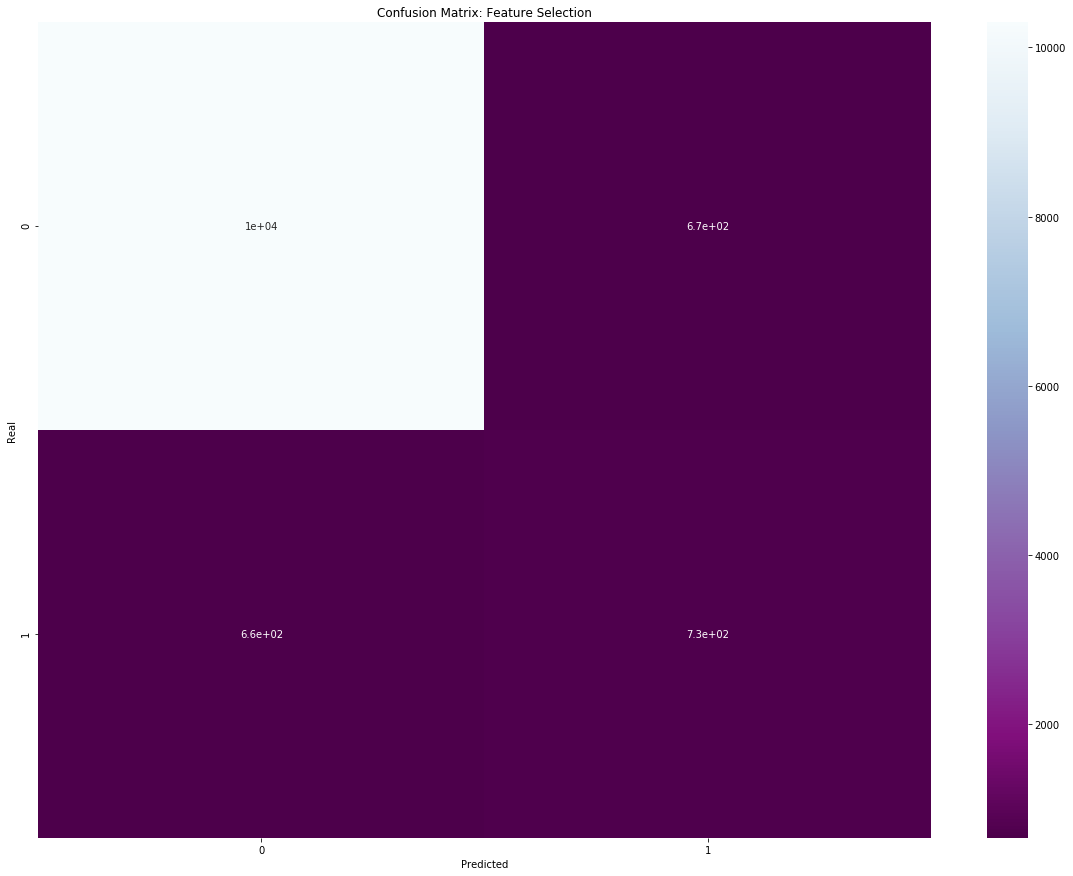

In [10]:
from sklearn.metrics import confusion_matrix


prediction = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, prediction)
plt.figure(figsize=(20,15))
plt.title("Confusion Matrix: Feature Selection")
sns.heatmap(conf_matrix, annot=True, cmap='BuPu_r')
plt.xlabel('Predicted')
plt.ylabel('Real')

In [11]:
n_calls_total = X_test.shape[0]
n_calls_total

12357

In [12]:
n_calls_model = np.count_nonzero(prediction == 1)
n_calls_model

1400

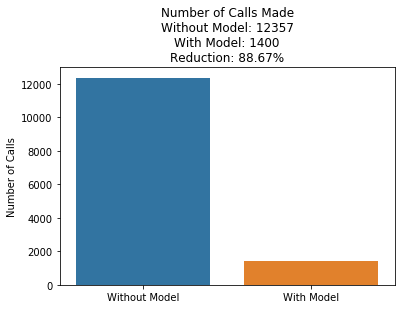

In [13]:
plt.figure()
plt.title('Number of Calls Made\nWithout Model: {}\nWith Model: {}\nReduction: {}%'.format(n_calls_total, 
                                                                                           n_calls_model, 
                                                                                           round(100 * (1 - n_calls_model 
                                                                                                        / n_calls_total), 2)))
plt.ylabel('Number of Calls')
sns.barplot(x=['Without Model', 'With Model'], y=[n_calls_total, n_calls_model])

In [14]:
total_open_acc = np.count_nonzero(y_test == 1)
total_open_acc

1392

In [15]:
model_open_acc = np.count_nonzero(np.logical_and(y_test == 1, prediction == 1))
model_open_acc

731

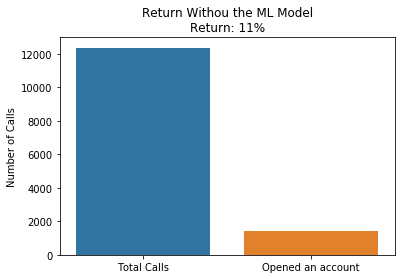

In [16]:
plt.figure()
plt.title('Return Withou the ML Model\nReturn: {}%'.format(round(100 * total_open_acc / n_calls_total), 2))
plt.ylabel('Number of Calls')
sns.barplot(x=['Total Calls', 'Opened an account'], y=[n_calls_total, total_open_acc])

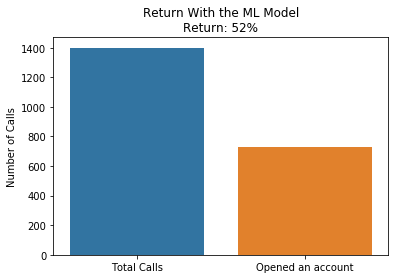

In [17]:
plt.figure()
plt.title('Return With the ML Model\nReturn: {}%'.format(round(100 * model_open_acc / n_calls_model), 2))
plt.ylabel('Number of Calls')
sns.barplot(x=['Total Calls', 'Opened an account'], y=[n_calls_model, model_open_acc])

# 9. Sending to Production
Now we will send the model to IBM Watson Machine Learning.

In [18]:
# The code was removed by Watson Studio for sharing.

In [19]:
production_model = client.repository.store_model(model, meta_props={'name': 'ada_boosting_v_1_2'}, 
                                                training_data=X_train, training_target=y_train)

In [21]:
import json

production_model_uid = client.repository.get_model_uid(production_model)

model_deployed = client.deployments.create(production_model_uid, 'Adaboosting Deployment')

scoring_endpoint = client.deployments.get_scoring_url(model_deployed)
print(scoring_endpoint)



#######################################################################################

Synchronous deployment creation for uid: '175deffc-4657-46ad-bcfe-6c025c270615' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='d8af2062-89eb-477c-b419-5d670d3fc627'
------------------------------------------------------------------------------------------------


https://us-south.ml.cloud.ibm.com/v3/wml_instances/8309f153-d073-45f3-96f4-0db3faed8f9e/deployments/d8af2062-89eb-477c-b419-5d670d3fc627/online
